# MCP pose classification

*TensorFlow pose classification from MoveNet data (adapted for 2022 Marina Central Project)*

This notebook is adapted from the [TensorFlow pose classification tutorial part 2](https://www.tensorflow.org/lite/tutorials/pose_classification) to use the pre-processed and classified pose data we have to train a model to recognise the poses, and convert it to be used in a DepthAI OAK camera.

# Preparation

This installs the required packages.

In [113]:
%cd /content/
!pip3 install -q opencv-python
!pip3 install blobconverter
!pip3 install openvino-dev
!rm -rf examples
!wget -q -O movenet_thunder.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/float16/4?lite-format=tflite
!git clone https://github.com/tensorflow/examples.git

pose_sample_rpi_path = os.path.join(os.getcwd(), 'examples/lite/examples/pose_estimation/raspberry_pi')
sys.path.append(pose_sample_rpi_path)

/content
ERROR: Operation cancelled by user
Cloning into 'examples'...
remote: Enumerating objects: 20667, done.
remote: Counting objects: 100% (2487/2487), done.
remote: Compressing objects: 100% (1084/1084), done.
remote: Total 20667 (delta 1204), reused 2134 (delta 1043), pack-reused 18180
Receiving objects: 100% (20667/20667), 34.15 MiB | 29.94 MiB/s, done.
Resolving deltas: 100% (11298/11298), done.


Import required packages

In [72]:
import csv
import cv2
import itertools
import re
import numpy as np
import pandas as pd
import os
import sys
import tempfile
import tqdm
import random

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import utils
from data import BodyPart


# Preprocess CSVs

First, parse CSVs outputted by MoveNet for training, and splits it into test/train CSVs.

The .csv file structure:

```
filename,x1,y1,x2,y2...x17,y17 (17 landmarks)
```

Required file structure:

```
pose_data
  pose_name_1.csv
  pose_name_2.csv
  ...
```

Mount Google Drive and import files into runtime (optional; files can be manually uploaded into `/content/pose_data` as needed

In [3]:
from google.colab import drive
drive.mount('/content/drive')
!rm -rf /content/pose_data/
!mkdir /content/pose_data/
!cp -r /content/drive/MyDrive/pose_data/* /content/pose_data/ # replace drive folder path as needed

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Consolidate CSVs. (Code adapted from [demo](https://github.com/geaxgx/depthai_movenet/blob/main/examples/yoga_pose_recognition/demo.py))

In [28]:
# parameters
pose_samples_folder = '/content/pose_data/'
file_extension = 'csv'
file_delimiter = ','
n_landmarks = 17
n_dimensions = 2

In [29]:
class_names = []
file_names = [name for name in os.listdir(pose_samples_folder) if name.endswith(file_extension)]
pose_samples = []
for i, file_name in enumerate(file_names):
  # Use file name as pose class name
  class_name = file_name[:-(len(file_extension) + 1)]
  class_names.insert(i, class_name)
  pose_samples.insert(i, [])
  # Parse CSV
  with open(os.path.join(pose_samples_folder, file_name)) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=file_delimiter)
    for row in csv_reader:
      assert len(row) == n_landmarks * n_dimensions + 1, 'Wrong number of values: {}'.format(len(row))
      landmarks = np.array(row[1:], np.float32).reshape([n_landmarks, n_dimensions])
      pose_sample = [ *row[1:], i, class_name]
      pose_samples[i].append(pose_sample)

## Split test-train
(adapted from pose classification tutorial)

In [30]:
test_split = 0.15

In [31]:
train_poses = []
test_poses = []

for i in range(len(class_names)):
  test_poses.insert(i, [])
  train_poses.insert(i, [])

  # Shuffle the data deterministically
  pose_samples[i].sort()
  random.seed(42)
  random.shuffle(pose_samples[i])

  test_count = int(len(pose_samples[i]) * test_split)

  for j, sample in enumerate(pose_samples[i]):
    if j < test_count:
      test_poses[i].append(sample)
    else:
      train_poses[i].append(sample)

Write test dataset and train dataset to respective CSVs.

In [9]:
train_csv_name = 'pose_train_data.csv'
test_csv_name = 'pose_test_data.csv'

landmark_names = [
    'nose',
    'left_eye', 
    'right_eye',
    'left_ear', 'right_ear',
    'left_shoulder', 'right_shoulder',
    'left_elbow', 'right_elbow',
    'left_wrist', 'right_wrist',
    'left_hip', 'right_hip',
    'left_knee', 'right_knee',
    'left_ankle', 'right_ankle',
]
csv_headers = [
    *itertools.chain.from_iterable([[name + '_x', name + '_y'] for name in landmark_names]),
    'class_no', 'class_name'
]

In [10]:
train_poses_rows = list(itertools.chain.from_iterable(train_poses))
test_poses_rows = list(itertools.chain.from_iterable(test_poses))

!cd /content/

with open(train_csv_name, 'w', newline='') as train_csv:
  writer = csv.writer(train_csv, delimiter=',')
  writer.writerow(csv_headers)
  for row in train_poses_rows:
    writer.writerow(row)

with open(test_csv_name, 'w', newline='') as test_csv:
  writer = csv.writer(test_csv, delimiter=',')
  writer.writerow(csv_headers)
  for row in test_poses_rows:
    writer.writerow(row)

# Train model

## Load data

In [32]:
def load_pose_landmarks(csv_path):
  """Loads a CSV created by MoveNetPreprocessor.
  
  Returns:
    X: Detected landmark coordinates (N, 17 * 2)
    y: Ground truth labels of shape (N, label_count)
    classes: The list of all class names found in the dataset
    dataframe: The CSV loaded as a Pandas dataframe features (X) and ground
      truth labels (y) to use later to train a pose classification model.
  """

  # Load the CSV file
  dataframe = pd.read_csv(csv_path)
  df_to_process = dataframe.copy()

  # Extract the list of class names
  classes = df_to_process.pop('class_name').unique()

  # Extract the labels
  y = df_to_process.pop('class_no')

  # Convert the input features and labels into the correct format for training.
  X = df_to_process.astype('float64')
  y = keras.utils.to_categorical(y)

  return X, y, classes, dataframe

In [33]:
# Load the train data
X, y, class_names, _ = load_pose_landmarks(train_csv_name)

# Split training data (X, y) into (X_train, y_train) and (X_val, y_val)
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.15)

In [34]:
# Load the test data
X_test, y_test, _, df_test = load_pose_landmarks(test_csv_name)

In [35]:
#@title FullBodyPoseEmbedder class
#@markdown Taken from demo.py. Remember to run the block even though
#@markdown the code is hidden.

class FullBodyPoseEmbedder(object):
  """Converts pose landmarks into embedding."""

  def __init__(self, torso_size_multiplier=2.5):
    # Multiplier to apply to the torso to get minimal body size.
    self._torso_size_multiplier = torso_size_multiplier

    # Names of the landmarks as they appear in the prediction.
    self._landmark_names = [
        'nose',
        'left_eye', 
        'right_eye',
        'left_ear', 'right_ear',
        'left_shoulder', 'right_shoulder',
        'left_elbow', 'right_elbow',
        'left_wrist', 'right_wrist',
        'left_hip', 'right_hip',
        'left_knee', 'right_knee',
        'left_ankle', 'right_ankle',
    ]

  def __call__(self, landmarks):
    """Normalizes pose landmarks and converts to embedding
    
    Args:
      landmarks - NumPy array with 3D landmarks of shape (N, 3).
    Result:
      Numpy array with pose embedding of shape (M, 3) where `M` is the number of
      pairwise distances defined in `_get_pose_distance_embedding`.
    """
    print(landmarks.shape[0])
    print(len(self._landmark_names))
    # assert landmarks.shape[0] == len(self._landmark_names), 'Unexpected number of landmarks: {}'.format(landmarks.shape[0])

    # Get pose landmarks.
    landmarks = np.copy(landmarks)

    # Normalize landmarks.
    landmarks = self._normalize_pose_landmarks(landmarks)

    # Get embedding. HERE
    embedding = self._get_pose_distance_embedding(landmarks)

    return embedding

  def _normalize_pose_landmarks(self, landmarks):
    """Normalizes landmarks translation and scale."""
    landmarks = np.copy(landmarks)

    # Normalize translation.
    pose_center = self._get_pose_center(landmarks)
    landmarks -= pose_center

    # Normalize scale.
    pose_size = self._get_pose_size(landmarks, self._torso_size_multiplier)
    landmarks /= pose_size
    # Multiplication by 100 is not required, but makes it eaasier to debug.
    landmarks *= 100

    return landmarks

  def _get_pose_center(self, landmarks):
    """Calculates pose center as point between hips."""
    left_hip = landmarks[self._landmark_names.index('left_hip')]
    right_hip = landmarks[self._landmark_names.index('right_hip')]
    center = (left_hip + right_hip) * 0.5
    return center

  def _get_pose_size(self, landmarks, torso_size_multiplier):
    """Calculates pose size.
    
    It is the maximum of two values:
      * Torso size multiplied by `torso_size_multiplier`
      * Maximum distance from pose center to any pose landmark
    """
    # This approach uses only 2D landmarks to compute pose size.
    landmarks = landmarks[:, :2]

    # Hips center.
    left_hip = landmarks[self._landmark_names.index('left_hip')]
    right_hip = landmarks[self._landmark_names.index('right_hip')]
    hips = (left_hip + right_hip) * 0.5

    # Shoulders center.
    left_shoulder = landmarks[self._landmark_names.index('left_shoulder')]
    right_shoulder = landmarks[self._landmark_names.index('right_shoulder')]
    shoulders = (left_shoulder + right_shoulder) * 0.5

    # Torso size as the minimum body size.
    torso_size = np.linalg.norm(shoulders - hips)

    # Max dist to pose center.
    pose_center = self._get_pose_center(landmarks)
    max_dist = np.max(np.linalg.norm(landmarks - pose_center, axis=1))

    return max(torso_size * torso_size_multiplier, max_dist)

  def _get_pose_distance_embedding(self, landmarks):
    """Converts pose landmarks into 3D embedding.
    We use several pairwise 3D distances to form pose embedding. All distances
    include X and Y components with sign. We differnt types of pairs to cover
    different pose classes. Feel free to remove some or add new.
    
    Args:
      landmarks - NumPy array with 3D landmarks of shape (N, 3).
    Result:
      Numpy array with pose embedding of shape (M, 3) where `M` is the number of
      pairwise distances.
    """
    embedding = np.array([
        # One joint.

        self._get_distance(
            self._get_average_by_names(landmarks, 'left_hip', 'right_hip'),
            self._get_average_by_names(landmarks, 'left_shoulder', 'right_shoulder')),

        self._get_distance_by_names(landmarks, 'left_shoulder', 'left_elbow'),
        self._get_distance_by_names(landmarks, 'right_shoulder', 'right_elbow'),

        self._get_distance_by_names(landmarks, 'left_elbow', 'left_wrist'),
        self._get_distance_by_names(landmarks, 'right_elbow', 'right_wrist'),

        self._get_distance_by_names(landmarks, 'left_hip', 'left_knee'),
        self._get_distance_by_names(landmarks, 'right_hip', 'right_knee'),

        self._get_distance_by_names(landmarks, 'left_knee', 'left_ankle'),
        self._get_distance_by_names(landmarks, 'right_knee', 'right_ankle'),

        # Two joints.

        self._get_distance_by_names(landmarks, 'left_shoulder', 'left_wrist'),
        self._get_distance_by_names(landmarks, 'right_shoulder', 'right_wrist'),

        self._get_distance_by_names(landmarks, 'left_hip', 'left_ankle'),
        self._get_distance_by_names(landmarks, 'right_hip', 'right_ankle'),

        # Four joints.

        self._get_distance_by_names(landmarks, 'left_hip', 'left_wrist'),
        self._get_distance_by_names(landmarks, 'right_hip', 'right_wrist'),

        # Five joints.

        self._get_distance_by_names(landmarks, 'left_shoulder', 'left_ankle'),
        self._get_distance_by_names(landmarks, 'right_shoulder', 'right_ankle'),
        
        self._get_distance_by_names(landmarks, 'left_hip', 'left_wrist'),
        self._get_distance_by_names(landmarks, 'right_hip', 'right_wrist'),

        # Cross body.

        self._get_distance_by_names(landmarks, 'left_elbow', 'right_elbow'),
        self._get_distance_by_names(landmarks, 'left_knee', 'right_knee'),

        self._get_distance_by_names(landmarks, 'left_wrist', 'right_wrist'),
        self._get_distance_by_names(landmarks, 'left_ankle', 'right_ankle'),

        # Body bent direction.

        # self._get_distance(
        #     self._get_average_by_names(landmarks, 'left_wrist', 'left_ankle'),
        #     landmarks[self._landmark_names.index('left_hip')]),
        # self._get_distance(
        #     self._get_average_by_names(landmarks, 'right_wrist', 'right_ankle'),
        #     landmarks[self._landmark_names.index('right_hip')]),
    ])

    return embedding

  def _get_average_by_names(self, landmarks, name_from, name_to):
    lmk_from = landmarks[self._landmark_names.index(name_from)]
    lmk_to = landmarks[self._landmark_names.index(name_to)]
    return (lmk_from + lmk_to) * 0.5

  def _get_distance_by_names(self, landmarks, name_from, name_to):
    lmk_from = landmarks[self._landmark_names.index(name_from)]
    lmk_to = landmarks[self._landmark_names.index(name_to)]
    return self._get_distance(lmk_from, lmk_to)

  def _get_distance(self, lmk_from, lmk_to):
    return lmk_to - lmk_from

## Define model

In [36]:
def get_center_point(landmarks, left_bodypart, right_bodypart):
  """Calculates the center point of the two given landmarks."""

  left = tf.gather(landmarks, left_bodypart.value, axis=1)
  right = tf.gather(landmarks, right_bodypart.value, axis=1)
  center = left * 0.5 + right * 0.5
  return center


def get_pose_size(landmarks, torso_size_multiplier=2.5):
  """Calculates pose size.

  It is the maximum of two values:
    * Torso size multiplied by `torso_size_multiplier`
    * Maximum distance from pose center to any pose landmark
  """
  # Hips center
  hips_center = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                 BodyPart.RIGHT_HIP)

  # Shoulders center
  shoulders_center = get_center_point(landmarks, BodyPart.LEFT_SHOULDER,
                                      BodyPart.RIGHT_SHOULDER)

  # Torso size as the minimum body size
  torso_size = tf.linalg.norm(shoulders_center - hips_center)

  # Pose center
  pose_center_new = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                     BodyPart.RIGHT_HIP)
  pose_center_new = tf.expand_dims(pose_center_new, axis=1)
  # Broadcast the pose center to the same size as the landmark vector to
  # perform substraction
  pose_center_new = tf.broadcast_to(pose_center_new,
                                    [tf.size(landmarks) // (17*2), 17, 2])

  # Dist to pose center
  d = tf.gather(landmarks - pose_center_new, 0, axis=0,
                name="dist_to_pose_center")
  # Max dist to pose center
  max_dist = tf.reduce_max(tf.linalg.norm(d, axis=0))

  # Normalize scale
  pose_size = tf.maximum(torso_size * torso_size_multiplier, max_dist)

  return pose_size


def normalize_pose_landmarks(landmarks):
  """Normalizes the landmarks translation by moving the pose center to (0,0) and
  scaling it to a constant pose size.
  """
  # Move landmarks so that the pose center becomes (0,0)
  pose_center = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                 BodyPart.RIGHT_HIP)
  pose_center = tf.expand_dims(pose_center, axis=1)
  # Broadcast the pose center to the same size as the landmark vector to perform
  # substraction
  pose_center = tf.broadcast_to(pose_center, 
                                [tf.size(landmarks) // (17*2), 17, 2])
  landmarks = landmarks - pose_center

  # Scale the landmarks to a constant pose size
  pose_size = get_pose_size(landmarks)
  landmarks /= pose_size

  return landmarks


def landmarks_to_embedding(landmarks_input):
  """Converts the input landmarks into a pose embedding."""
  # Reshape the flat input into a matrix with shape=(17, 2)
  reshaped_inputs = keras.layers.Reshape((17, 2))(landmarks_input)

  # Normalize landmarks 2D
  landmarks = normalize_pose_landmarks(reshaped_inputs[:, :])

  # Flatten the normalized landmark coordinates into a vector
  embedding = keras.layers.Flatten()(landmarks)

  return embedding

In [37]:
# Define the model
inputs = tf.keras.Input(shape=(34))
embedding = landmarks_to_embedding(inputs)

layer = keras.layers.Dense(128, activation=tf.nn.relu6)(embedding)
layer = keras.layers.Dropout(0.5)(layer)
layer = keras.layers.Dense(64, activation=tf.nn.relu6)(layer)
layer = keras.layers.Dropout(0.5)(layer)
outputs = keras.layers.Dense(len(class_names), activation="softmax")(layer)

model = keras.Model(inputs, outputs)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 34)]         0           []                               
                                                                                                  
 reshape_2 (Reshape)            (None, 17, 2)        0           ['input_3[0][0]']                
                                                                                                  
 tf.__operators__.getitem_2 (Sl  (None, 17, 2)       0           ['reshape_2[0][0]']              
 icingOpLambda)                                                                                   
                                                                                                  
 tf.compat.v1.gather_18 (TFOpLa  (None, 2)           0           ['tf.__operators__.getitem_

In [38]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Add a checkpoint callback to store the checkpoint that has the highest
# validation accuracy.
checkpoint_path = "weights.best.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
earlystopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                              patience=20)

# Start training
history = model.fit(X_train, y_train,
                    epochs=200,
                    batch_size=16,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint, earlystopping])

Epoch 1/200
48/49 [============================>.] - ETA: 0s - loss: 1.9492 - accuracy: 0.3398
Epoch 1: val_accuracy improved from -inf to 0.42647, saving model to weights.best.hdf5
49/49 [==============================] - 1s 9ms/step - loss: 1.9489 - accuracy: 0.3403 - val_loss: 1.8217 - val_accuracy: 0.4265
Epoch 2/200
47/49 [===========================>..] - ETA: 0s - loss: 1.6280 - accuracy: 0.4694
Epoch 2: val_accuracy improved from 0.42647 to 0.54412, saving model to weights.best.hdf5
49/49 [==============================] - 0s 4ms/step - loss: 1.6226 - accuracy: 0.4740 - val_loss: 1.4771 - val_accuracy: 0.5441
Epoch 3/200
45/49 [==========================>...] - ETA: 0s - loss: 1.3170 - accuracy: 0.5514
Epoch 3: val_accuracy improved from 0.54412 to 0.83824, saving model to weights.best.hdf5
49/49 [==============================] - 0s 4ms/step - loss: 1.3020 - accuracy: 0.5597 - val_loss: 1.1490 - val_accuracy: 0.8382
Epoch 4/200
45/49 [==========================>...] - ETA: 0s 

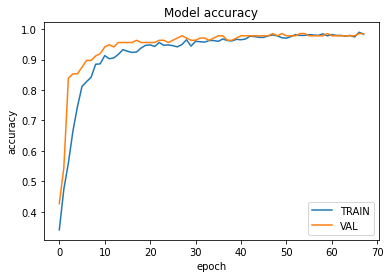

In [39]:
# Visualize the training history to see whether you're overfitting.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()

In [40]:
# Evaluate the model using the TEST dataset
loss, accuracy = model.evaluate(X_test, y_test)

5/5 [==============================] - 0s 3ms/step - loss: 0.0797 - accuracy: 0.9809


## Draw the confusion matrix to better understand the model performance

Confusion matrix, without normalization

Classification Report:
               precision    recall  f1-score   support

       cobra       1.00      1.00      1.00         9
 downwarddog       1.00      1.00      1.00         9
     leftdab       0.97      1.00      0.98        30
    mountain       1.00      0.50      0.67         6
    rightdab       1.00      1.00      1.00        30
       squat       1.00      1.00      1.00        30
      surren       1.00      1.00      1.00        30
   triangle1       0.87      1.00      0.93        13

    accuracy                           0.98       157
   macro avg       0.98      0.94      0.95       157
weighted avg       0.98      0.98      0.98       157



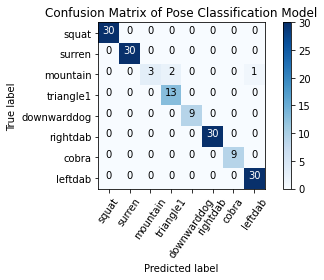

In [41]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """Plots the confusion matrix."""
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print('Confusion matrix, without normalization')

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=55)
  plt.yticks(tick_marks, classes)
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")

  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.tight_layout()

# Classify pose in the TEST dataset using the trained model
y_pred = model.predict(X_test)

# Convert the prediction result to class name
y_pred_label = [class_names[i] for i in np.argmax(y_pred, axis=1)]
y_true_label = [class_names[i] for i in np.argmax(y_test, axis=1)]

# Plot the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
plot_confusion_matrix(cm,
                      class_names,
                      title ='Confusion Matrix of Pose Classification Model')

# Print the classification report
print('\nClassification Report:\n', classification_report(y_true_label,
                                                          y_pred_label))

# Export

## Export a Trained Inference Graph
Once your training job is complete, you need to extract the newly trained inference graph, which will be later used to perform the object detection. This can be done as follows:

In [42]:
#clean output directory if necessary to start fresh:

%cd /content/
!rm -rf /content/model/ 
os.makedirs('/content/model/', exist_ok=True)

/content


In [43]:
output_directory = '/content/model/'
model_dir = '/content/model/saved_model/'

# Save the entire model as a SavedModel.
model.save(model_dir)

# freeze model
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2
full_model = tf.function(lambda inputs: model(inputs))    
full_model = full_model.get_concrete_function([tf.TensorSpec(model_input.shape, model_input.dtype) for model_input in model.inputs]) # Get frozen ConcreteFunction    
frozen_func = convert_variables_to_constants_v2(full_model)
frozen_func.graph.as_graph_def() # Save frozen graph from frozen ConcreteFunction to hard drive
tf.io.write_graph(graph_or_graph_def=frozen_func.graph, logdir=output_directory+"frozen/", name="frozen_inference_graph.pb", as_text=False)


INFO:tensorflow:Assets written to: /content/model/saved_model/assets


'/content/model/frozen/frozen_inference_graph.pb'

# Prepare the TF model for DepthAI. 
# First, we convert the model to OpenVINO Intermediate Representation (IR)
(This can be used to run inference on OpenVINO, but for our purpose it is only a step in the preparation for DepthAI)
# In order to run the model on DepthAI modules, we then compile the IR obtained above to a .blob

## Convert TF model to OpenVINO IR

In [63]:
#CONVERT TF MODEL to OPEN VINO IRv10
%cd "/content/model/frozen"
!mo \
    --input_model frozen_inference_graph.pb \
    --output_dir signs \
    --data_type FP16 \
    --input_shape [34,17,2]
    

/content/model/frozen
Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	/content/model/frozen/frozen_inference_graph.pb
	- Path for generated IR: 	/content/model/frozen/signs
	- IR output name: 	frozen_inference_graph
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	[34,17,2]
	- Mean values: 	Not specified
	- Scale values: 	Not specified
	- Scale factor: 	Not specified
	- Precision of IR: 	FP16
	- Enable fusing: 	True
	- Enable grouped convolutions fusing: 	True
	- Move mean values to preprocess section: 	None
	- Reverse input channels: 	False
TensorFlow specific parameters:
	- Input model in text protobuf format: 	False
	- Path to model dump for TensorBoard: 	None
	- List of shared libraries with TensorFlow custom layers implementation: 	None
	- Update the configuration file with input/output node names: 

## Compile the IR model to a .blob for use on DepthAI modules/platform

In [109]:
import os
os.environ['IR_XML'] = "/content/model/frozen/signs/frozen_inference_graph.xml"
os.environ['IR_BIN'] = "/content/model/frozen/signs/frozen_inference_graph.bin"
os.environ['BLOB_DIR'] = "/content/model/saved_model_blob/"

!rm -rf $BLOB_DIR && mkdir $BLOB_DIR && cd $BLOB_DIR
!blobconverter \
      -o $BLOB_DIR \
      -ox $IR_XML \
      -ob $IR_BIN \
      --shaves 7

[==================================================]
Done
/content/model/saved_model_blob/frozen_inference_graph_openvino_2021.4_7shave.blob


##Now you can download your .blob file and run it on the DepthAI module/platform
To download locally, use the file explorer on the left to locate the file in the `$BLOB_DIR` folder, then right click download. Colab takes a few seconds to prepare the file, then the download prompt will appear.

## To run the .blob in DepthAI, follow the tutorial:
https://docs.luxonis.com/en/latest/pages/tutorials/hello_world/



[Optional] to convert the blob locally, download the IR files .bin and .xml and follow these instructions:

https://docs.luxonis.com/en/latest/pages/tutorials/local_convert_openvino/

In [114]:
#compress the IR_V10 folder
%cd /content/
!tar cvf model.tar.gz model


/content
model/
model/saved_model/
model/saved_model/assets/
model/saved_model/variables/
model/saved_model/variables/variables.index
model/saved_model/variables/variables.data-00000-of-00001
model/saved_model/keras_metadata.pb
model/saved_model/saved_model.pb
model/saved_model_blob/
model/saved_model_blob/frozen_inference_graph_openvino_2021.4_7shave.blob
model/frozen/
model/frozen/movenet_thunder.tflite
model/frozen/frozen_inference_graph.pb
model/frozen/signs/
model/frozen/signs/frozen_inference_graph.bin
model/frozen/signs/frozen_inference_graph.xml
model/frozen/signs/frozen_inference_graph.mapping


In [115]:
#download the compressed IRv10 folder locally
#or can use file navigator on the left to move it to your gdrive
from google.colab import files
files.download("model.tar.gz")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>